<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Profesional III Departamento de Datos no Estructurados  </h1>


<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problmeas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información. 
</p>


**Nota** <br>
Tenga en cuneta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habiliadades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

# **Clasificación de Imágenes**
A continuación se presenta mi propuesta para realizar la clasificación de páginas o documentos con información y sin información (en blanco).

Se trata de un modelo de ***red neuronal convolucional (CNN)***. Este tipo de redes neuronales artificiales ha sido usado con éxito para reconocimiento de imágenes, por lo cual se espera un buen desempeño de clasificación para este problema.

Como ventaja sobre el Machine Learning, el Deep Learning evita una etapa de extracción de características, por lo cual se pueden ingresar las imágenes casi sin preprocesamiento.

![](https://media.geeksforgeeks.org/wp-content/uploads/home/new5-660x290.jpg)

`Fuente: https://www.geeksforgeeks.org/object-detection-vs-object-recognition-vs-image-segmentation/`

#### **NOTA:** El notebook presenta los resultados obtenidos tras entrenar y validar el modelo. Debido a la naturaleza de los entrenamientos de las redes neuronales, no se garantiza que si se ejecutan las celdas se llegue al mismo resultado presentado. Este podría cambiar incluso conservando los mismos parámetros.

In [ ]:
# Importar librerías empleadas en el notebook

import tensorflow as tf
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.io as sio 

from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models


# 1. Importación de las imágenes
Se subió el dataset de las imágenes a Google Drive, de donde se van a tomar para realizar su procesamiento. Para esto se empleó el comando `mount`, como se indica a continuación.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Se cargaron las imágenes guardadas en el drive como arreglos de vectores (ndarray). A manera de preprocesamiento, **se redujeron sus dimensiones**. Al ser imágenes en alta definición, el procesarlas en esta definición podría ser de alta carga computacional, además, las CNN tienden a tener buen desempeño incluso con imágenes de pequeños tamaños.

2. Se tomó como base para la altura de las imágenes el tamaño de 256 px, y el ancho 197 px. Estos valores se calcularon con el fin de no alterar en gran manera la relación original de la mayoría de las imágenes.

3. También se **normalizó el valor de las imágenes, dividiendo los arreglos en 255**, para que los valores estén entre 0 y 1. Esto ayuda a mejorar el rendimiento de clasificación en redes neuronales.

In [ ]:
from google.colab.patches import cv2_imshow

#### CARGA DE IMAGENES EN BLANCO (el mismo proceso anterior) ####

# ruta en el directorio de las imágenes en blanco
ruta_blancos = "/content/drive/MyDrive/Davivienda/Dataset_imagenes/Blanco" 
ruta_documentos = "/content/drive/MyDrive/Davivienda/Dataset_imagenes/Documentos"
 
# creación de un arreglo vacío, aquí se agregarán los arreglos de cada imagen en blanco tomada del dataset 
data_blancos = []
data_documentos = []

###### SE AGREGAN LAS IMÁGENES BLANCAS EN UN ARREGLO DE VECTORES #######
# este ciclo empieza a agregar cada una de las imágenes en blanco del dataset al arreglo data_blancos
for img in os.listdir(ruta_blancos):    
  img = cv2.imread(os.path.join(ruta_blancos,img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
  data_blancos.append([img])                             # append para agregar cada imagen al arreglo data_blancos

data_blancos = np.array(data_blancos)

###### SE AGREGAN LAS IMÁGENES DE DOCUMENTOS EN UN ARREGLO DE VECTORES #######
for img in os.listdir(ruta_documentos):
  img = cv2.imread(os.path.join(ruta_documentos,img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
  data_documentos.append([img])

data_documentos = np.array(data_documentos)

print("Cantidad de imágenes sin información (en blanco): ",len(data_blancos))
print("Cantidad de imágenes con documentos: ",len(data_documentos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Cantidad de imágenes sin información (en blanco):  147
Cantidad de imágenes con documentos:  100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# 2. Estructuración de los datos
Una vez las imágenes han sido almacenadas en dos arreglos de vectores, se procede a hacer su repartición en datos de prueba y de entrenamiento. Esto se hace ya que las CNN necesitan una etapa de entrenamiento y otra de prueba.

Con el fin de alcanzar un entrenamiento y prueba más robustos, se tomó un **40 % de los datos para prueba y el 60 % para entrenamiento**.

Se emplea la función de `train_test_split` de la librería Sklearn para una partición aleatoria de los datos.

In [ ]:
from sklearn.model_selection import train_test_split    # importar la función para particionar el dataset

train_documentos, test_documentos = train_test_split(data_documentos, 
                                                     test_size=0.4, random_state=1)       # 40 % para datos de prueba 
train_blancos, test_blancos = train_test_split(data_blancos, 
                                               test_size=0.4, random_state=1)             # 40 % para datos de prueba 

print("Tamaño de datos de prueba con documentos: ",len(test_documentos))
print("Tamaño de datos de entranamiento con documentos: ",len(train_documentos))
print("Tamaño de datos de prueba en blanco: ",len(test_blancos))
print("Tamaño de datos de entrenamiento en blanco: ",len(train_blancos))

Tamaño de datos de prueba con documentos:  40
Tamaño de datos de entranamiento con documentos:  60
Tamaño de datos de prueba en blanco:  59
Tamaño de datos de entrenamiento en blanco:  88


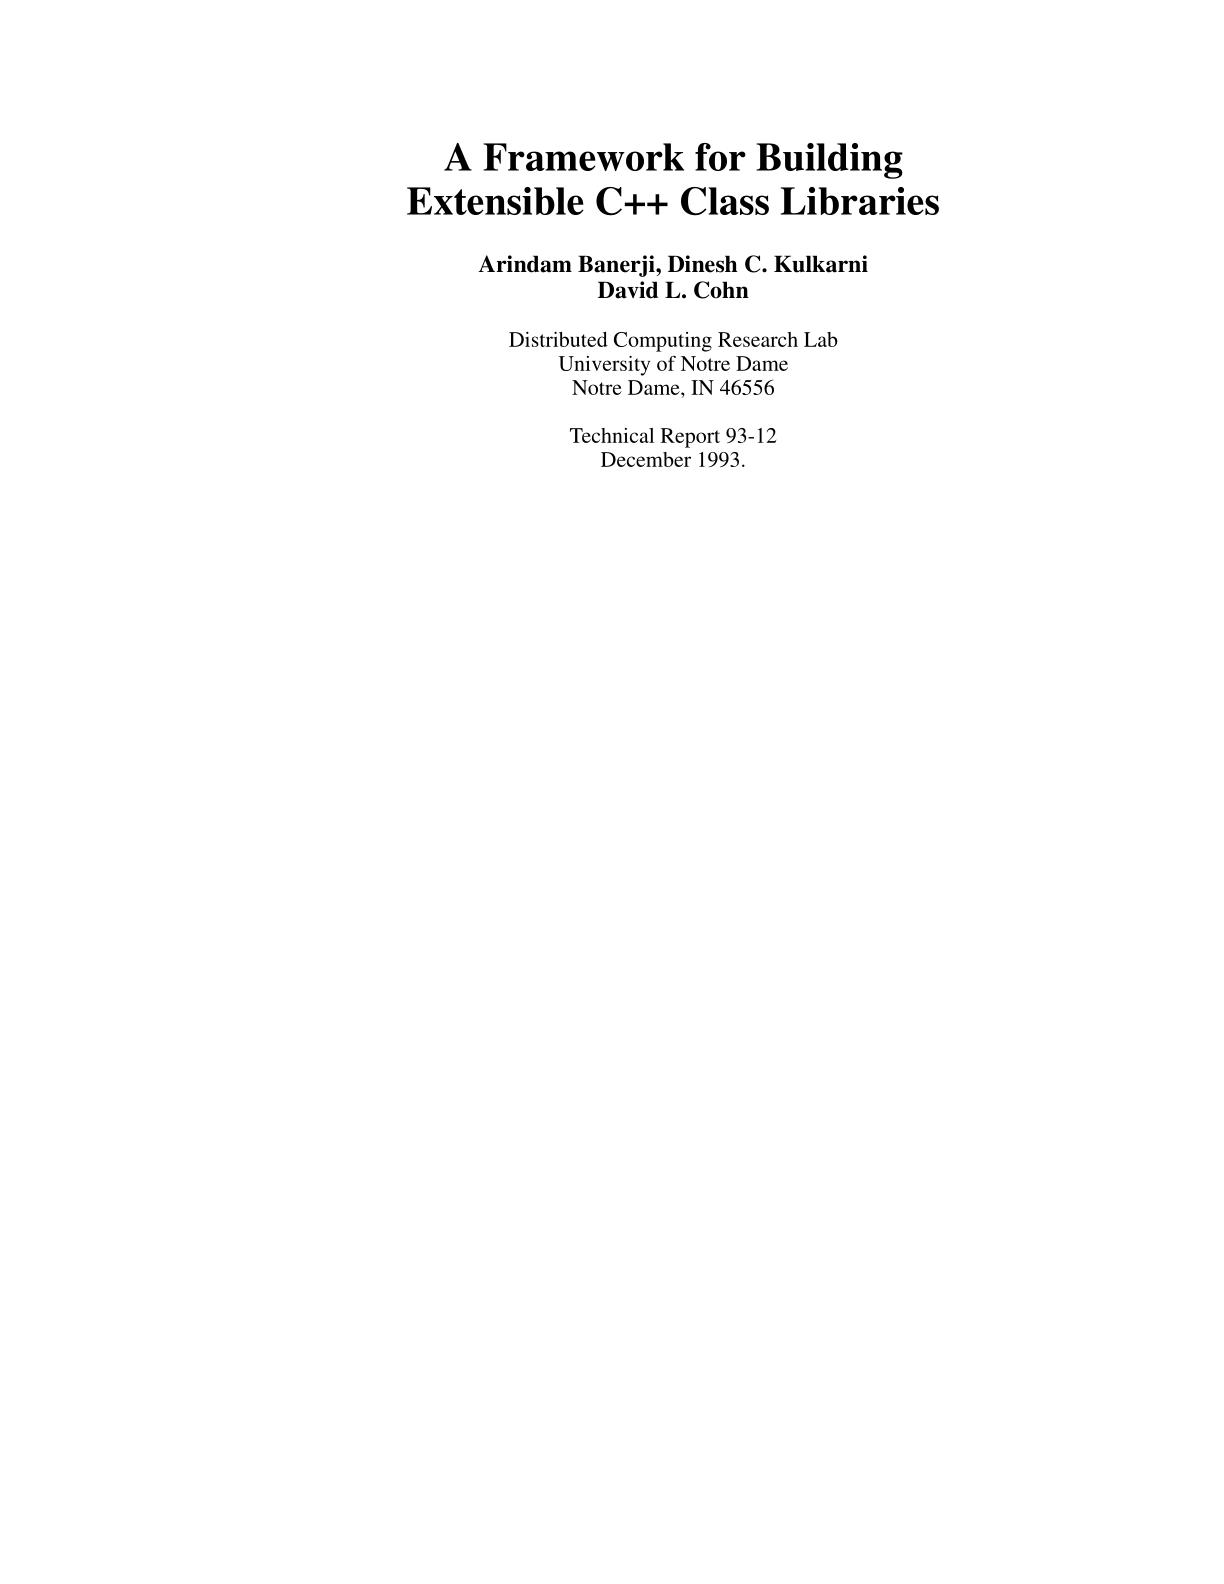

In [ ]:
# Visualización de la imagen en la posición 10 de los documentos de entrenamiento
img = train_documentos[10][0]
cv2_imshow(img)  

In [ ]:
##### PRE PROCESAMIENTO DE LOS DATOS - RESIZE Y NORMALIZACIÓN #####

resize_documentos_train = []
resize_documentos_test = []
resize_blancos_train = []
resize_blancos_test = []

wsize = 197
baseheight = 256

lista_originales = [train_documentos, test_documentos, train_blancos, test_blancos]
lista_resize = [resize_documentos_train, resize_documentos_test, resize_blancos_train, resize_blancos_test]

# se hace un ciclo para almacenar en otros arreglos resize las imágenes con el tamaño reducido y la normalización
for data_original,data_resize in zip(lista_originales,lista_resize):
  for i in range(len(data_original)):   
    img_resized = data_original[i][0]
    img_resized = cv2.resize(img_resized, (wsize,baseheight), interpolation = cv2.INTER_AREA)
    img_resized = img_resized / 255                                     # se normalizan los valores de las imagenes en valores de 0 a 1
    data_resize.append([img_resized])                                   # append para agregar cada imagen al arreglo data_blancos

# ajuste de dimensiones de los arreglos
resize_documentos_train = np.array(resize_documentos_train)
resize_documentos_train = np.squeeze(resize_documentos_train, axis=1)

resize_documentos_test = np.array(resize_documentos_test)
resize_documentos_test = np.squeeze(resize_documentos_test, axis=1)

resize_blancos_train = np.array(resize_blancos_train)
resize_blancos_train = np.squeeze(resize_blancos_train, axis=1)

resize_blancos_test = np.array(resize_blancos_test)
resize_blancos_test = np.squeeze(resize_blancos_test, axis=1)

print("Tamaño del arreglo de documentos para entrenamiento: ",resize_documentos_train.shape)
print("Tamaño del arreglo de documentos para prueba: ",resize_documentos_test.shape)
print("Tamaño del arreglo de blancos para entrenamiento: ",resize_blancos_train.shape)
print("Tamaño del arreglo de blancos para prueba: ",resize_blancos_test.shape)

Tamaño del arreglo de documentos para entrenamiento:  (60, 256, 197, 3)
Tamaño del arreglo de documentos para prueba:  (40, 256, 197, 3)
Tamaño del arreglo de blancos para entrenamiento:  (88, 256, 197, 3)
Tamaño del arreglo de blancos para prueba:  (59, 256, 197, 3)


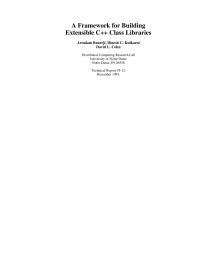

In [ ]:
img = resize_documentos_train[10]

cv2_imshow(255*img)  # visualización de la imágen en la posición 10 de documentos train con tamaño reducido

Se proecede a concatenar los datos de prueba de la clase 0 (documentos) y la clase 1 (en blanco) en un solo arreglo de `test_data` y `train_data`.

También se generan los vectores con los targets o etiquetas para los datos de prueba y entrenamiento. Se usa el valor de 0 para hacer referencia a los datos con documentos y 1 a los datos en blanco.

In [ ]:
# concatenación de los datos de cada clase para prueba y entrenamiento
test_data = np.concatenate((resize_documentos_test,resize_blancos_test), axis=0)
train_data = np.concatenate((resize_documentos_train,resize_blancos_train), axis=0)

print("Cantidad total de datos de prueba: ",test_data.shape[0])
print("Cantidad total de datos de entrenamiento: ",train_data.shape[0])

# creación de los vectores con las etiquetas para datos de prueba y entrenamiento
test_targets = np.concatenate((np.zeros(test_documentos.shape[0]),
                               np.ones(test_blancos.shape[0])),axis=0)
train_targets = np.concatenate((np.zeros(train_documentos.shape[0]),
                                np.ones(train_blancos.shape[0])),axis=0)

# ajuste de las dimensiones de los vectores
test_targets = np.reshape(test_targets,(test_targets.shape[0],1))
train_targets = np.reshape(train_targets,(train_targets.shape[0],1))

# print(test_targets.shape)
# print(train_targets.shape)

Cantidad total de datos de prueba:  99
Cantidad total de datos de entrenamiento:  148


# 3. Elaboración de la red neuronal convolucional (CNN)
Una vez el dataset se ha particionado en datos de prueba y de entrenamiento, se procede a construir el modelo de la red neuronal convolucional (CNN). Una CNN generalmente, consta por lo menos de dos capas llamadas Convolucional y Pooling, en donde se realiza una extracción de las características principales de las imágenes.

Se pueden usar varias capas de convolución y de pooling, generalmente una después de otra, variando los tamaños de estas capas. **En este caso se emplearon 3 capas de cada una, empleando la función de activación ReLU.**

El framework de `TensorFlow` se utilizó para poner en marcha este diseño de CNN.

A continuación se presenta la construcción del modelo, con 3 capas de convolución y 3 de MaxPooling.


In [ ]:
cnn_model = models.Sequential()                                                             # Creación del modelo de la CNN
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 197, 3)))      # Primera capa de convolución
cnn_model.add(layers.MaxPooling2D((2, 2)))                                                  # Primera capa de maxpooling
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))                                 # Segunda capa de convolución
cnn_model.add(layers.MaxPooling2D((2, 2)))                                                  # Segunda capa de maxpooling
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))                                 # Tercera capa de convolución
cnn_model.add(layers.MaxPooling2D((2, 2)))                                                  # Tercera capa de maxpooling

cnn_model.summary()                                                                         # Resumen del modelo hasta ahora

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 195, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 97, 16)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 95, 32)       4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 45, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 22, 64)      

Para realizar la clasificación de las imágenes a partir de las características extraídas por las anteriores capas, se añade al modelo de la CNN una capa donde se "aplastan" los arreglos de características (`Flatten`), convirtiéndolos en un vector que será la entrada a una red neuronal Full Conected de 256 neuronas.

Como se trata un problema de clasificación binario, la capa de salida consiste de una sola neurona con función de activación sigmoidal. 

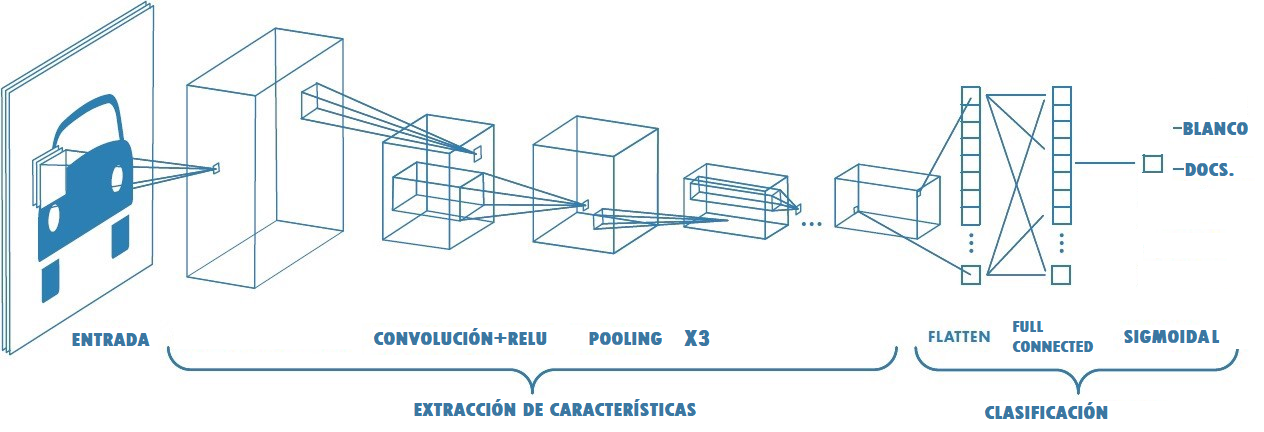

- Diagrama del modelo de la CNN elaborada

In [ ]:
cnn_model.add(layers.Flatten())                                       # Capa para "aplastar" el arreglo
cnn_model.add(layers.Dense(256, activation='relu'))                   # Red neuronal full connected
cnn_model.add(layers.Dense(1, activation='sigmoid'))                  # Capa de salida de la red neuronal

cnn_model.summary()                                                   # Resumen del modelo

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 195, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 97, 16)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 95, 32)       4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 45, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 22, 64)      

Finalmente se entrena el modelo con los datos y targets de entrenamiento. Según la literatura se recomiendan `RMSprop` para optimizar el aprendizaje y la función de costo `Binary crossentropy`.

Se encontró que existe un buen desempeño con un entrenamiento de 15 épocas (epochs).

In [ ]:
# Parámetros para el entrenamiento del modelo
cnn_model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])                     

history = cnn_model.fit(train_data, train_targets, epochs=15, 
                    validation_data=(test_data, test_targets))

Epoch 1/15
5/5 [==============================] - 6s 1s/step - loss: 10.2362 - accuracy: 0.4054 - val_loss: 0.6944 - val_accuracy: 0.4040
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 0.9698 - accuracy: 0.5000 - val_loss: 0.5096 - val_accuracy: 0.9798
Epoch 3/15
5/5 [==============================] - 6s 1s/step - loss: 0.7488 - accuracy: 0.7230 - val_loss: 0.6282 - val_accuracy: 0.4040
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 0.8682 - accuracy: 0.5405 - val_loss: 0.3183 - val_accuracy: 0.9293
Epoch 5/15
5/5 [==============================] - 6s 1s/step - loss: 0.7429 - accuracy: 0.6689 - val_loss: 1.0399 - val_accuracy: 0.4141
Epoch 6/15
5/5 [==============================] - 6s 1s/step - loss: 0.9077 - accuracy: 0.6284 - val_loss: 4.0260 - val_accuracy: 0.4040
Epoch 7/15
5/5 [==============================] - 6s 1s/step - loss: 0.8392 - accuracy: 0.8311 - val_loss: 1.0229 - val_accuracy: 0.5960
Epoch 8/15
5/5 [========================

A continuación se presenta la **curva de aprendizaje del modelo**, donde se observa la evolución en la precisión en la clasificación de las imágenes a lo largo de las épocas.

4/4 - 1s - loss: 0.0374 - accuracy: 0.9798 - 961ms/epoch - 240ms/step


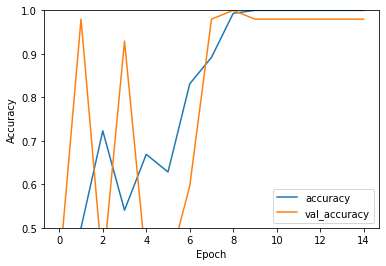

In [ ]:
#### GRÁFICA DEL ENTRENAMIENTO #### 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(test_data,  test_targets, verbose=2)

predictions = (cnn_model.predict(test_data) > 0.5).astype("int32")      # Se obtiene el vector de las predicciones hechas por el modelo para los datos de prueba

# 4. Interpretación de Resultados
Con el fin de evaluar el desempeño del modelo, se graficó la **matriz de confusión con los 99 datos de prueba.** 

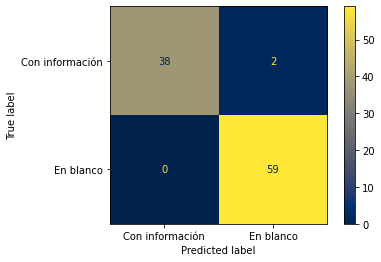

In [ ]:
classes_names = ['Con información', 'En blanco']          # Nombres de las clases

def plot_conf_mat(target,predicted):
    y_target = pd.Series(target, name='Target')
    y_pred = pd.Series(predicted, name='Predicted')
 
    cm = confusion_matrix(y_target, y_pred)               # Construcción de la matriz de confusión a partir de los targets y las predicciones hechas por el modelo

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
    disp.plot(cmap='cividis')                    

# ajuste de dimensiones
predictions = np.reshape(predictions, (test_targets.shape[0],))
test_labels = np.reshape(test_targets, (test_targets.shape[0],))

plot_conf_mat(test_labels, predictions)                   # Gráfico de la matriz de confusión      

Se encontró que hubo ***dos imágenes mal clasificadas***, las cuales están etiquetadas como documentos con información, y fueron clasificadas erróneamente como documentos en blanco.

Las imágenes en cuestión se presentan a continuación. Se nota que es un error comprensible, ya que **se trata de un documentos con muy poco texto**, similar a algunas imágenes en el dataset de documentos en blanco.

Este es un error que incluso, por despiste, un ser humano habría podido cometer. No se descarta que con un mejor ajuste de los hiperparámetros del modelo se pudiese llegar a una clasificación perfecta.

Etiqueta real de la imagen errada 1:  0.0
Predicción del clasificador:  1 



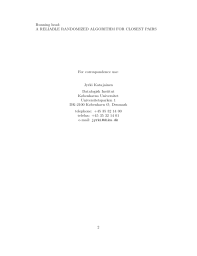

Etiqueta real de la imagen errada 2:  0.0
Predicción del clasificador:  1 



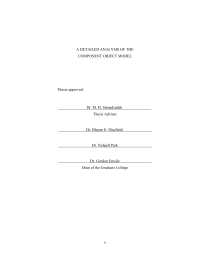

In [ ]:
print("Etiqueta real de la imagen errada 1: ",test_labels[21])
print("Predicción del clasificador: ",predictions[21],"\n")

cv2_imshow(255*test_data[21])  

print("Etiqueta real de la imagen errada 2: ",test_labels[11])
print("Predicción del clasificador: ",predictions[11],"\n")

cv2_imshow(255*test_data[11])  

Como se está trabajando con un ***dataset desbalanceado*** (es decir que no hay la misma cantidad de imágenes en blanco y documentos) ***no es suficiente confiar en la precisión del modelo*** (número de aciertos/número total de datos).

Para esto se calcularon ***otras métricas*** que se recomiendan para problemas de clasificación con datasets desbalanceados, tales como la precisión balanceada, el F1 score y el coeficiente de correlación de Matthews (MCC).

Nuevamente se empleó la librería de Sklearn para el cálculo de estas métricas de desempeño.

Precisión total:  98.0 %
Precisión balanceada:  97.5 %
F1 score:  0.983
Coeficiente de correlación de Matthews:  0.959 



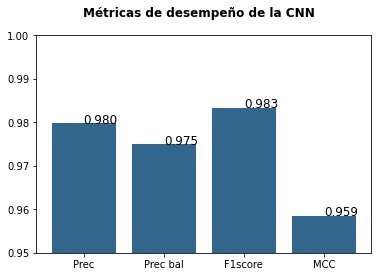

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef

##### CÁLCULO DE LAS MÉTRICAS DE DESEMPEÑO #####

accuracy_score = accuracy_score(test_labels, predictions)
balanced_accuracy = balanced_accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
mcc = matthews_corrcoef(test_labels, predictions)

print("Precisión total: ","{:.1f}".format(accuracy_score*100),"%")
print("Precisión balanceada: ","{:.1f}".format(balanced_accuracy*100),"%")
print("F1 score: ","{:.3f}".format(f1))
print("Coeficiente de correlación de Matthews: ","{:.3f}".format(mcc),"\n")

##### GRÁFICA DE LAS MÉTRICAS CALCULADAS #####

fig, ax = plt.subplots()
fig.suptitle("Métricas de desempeño de la CNN",fontweight="bold")

y = [accuracy_score,balanced_accuracy,f1,mcc]
x = ['Prec', 'Prec bal', 'F1score', 'MCC']

ax.set_ylim([0.95, 1])
ax.bar(x, y,color=(0.2, 0.4, 0.55, 1))
for i,j in zip(x,y):
    ax.text(i,j,"{:.3f}".format(j),size=12)

plt.show()

De los resultados presentados se puede llegar a las siguientes ***conclusiones***:

1.   El modelo elaborado clasificó con éxito 97 de 99 imágenes de prueba, las dos que no fueron clasificadas correctamente son imágenes que contienen poco texto. 

2.   Todas las métricas de desempeño calculadas se encuentran entre 0.95 y 0.98, lo que quiere decir que ***el modelo discrimina bien entre documentos con y sin información***.

3.   Según las imágenes mal clasificadas se puede observar una debilidad en el modelo. Sería más deseable que el modelo se equivocara con las imágenes sin información, ya que al clasificar equivocadamente las imágenes de documentos ***se corre el riesgo de perder información valiosa***.

4.  El problema del punto anterior se podría corregir empleando una opción de rechazo en la clasificación. Se trata de poner un "umbral de seguridad" en la clasificación. Por decirlo de una manera: ***si el clasificador no está bastante seguro de su decisión es preferible que no clasifique la imagen*** y la reporte al usuario en otra carpeta.

5.  El modelo se construyó con los parámetros más usados para redes neuronales convolucionales. Esto quiere decir que esta técnica es apropiada para este tipo de problemas e incluso ***se podría elevar su desempeño ajustando mejor sus parámetros.***

6. Otra opción para tratar el problema del dataset desbalanceado es usar la técnica de ***data agumentation***. Esta técnica permite aumentar el número de datos a partir de los datos presentes en el dataset, añadiendo ruido y rotaciones. No obstante, no se empleó en este caso.



# 5. Generación de carpetas de salida
Por último, se guardan las imágenes clasificadas en carpetas de salida "docs_con_contenido" y "docs_sin_contenido".

In [ ]:
docs_path = '/content/drive/MyDrive/Davivienda/docs_con_contenido'
blancos_path = '/content/drive/MyDrive/Davivienda/docs_sin_contenido'

i_docs = 0      # índice para el nombre de las imágenes con documentos 
i_blanks = 0    # índice para el nombre de las imágenes en blanco
j=0

for i in predictions[:len(test_documentos)]:                        # Se guardan las imágenes del arreglo de test con documentos
  img_to_save = test_documentos[j][0]
  if i == 0:
    cv2.imwrite(docs_path+'/doc_con_contenido'+str(i_docs)+'.jpg', img_to_save)     # Guarda en la dirección de docuentos si la clase es 0
    i_docs = i_docs+1                                                               
  else:
    cv2.imwrite(blancos_path+'/doc_sin_contenido'+str(i_blanks)+'.jpg', img_to_save)   # Guarda en la dirección de docuentos si la clase es 1
    i_blanks = i_blanks+1                                                           
  j=j+1

j=0
for i in predictions[len(test_documentos):]:                        # Se guardan las imágenes del arreglo de test con documentos en blanco
  img_to_save = test_blancos[j][0]
  if i == 0:
    cv2.imwrite(docs_path+'/doc_con_contenido'+str(i_docs)+'.jpg', img_to_save)          # Guarda en la dirección de docuentos si la clase es 0
    i_docs = i_docs+1
  else:
    cv2.imwrite(blancos_path+'/doc_sin_contenido'+str(i_blanks)+'.jpg', img_to_save)       # Guarda en la dirección de docuentos si la clase es 1
    i_blanks = i_blanks+1
  j=j+1
